In [ ]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

%reload_ext autoreload
%autoreload 2

Found 3 images in data folder


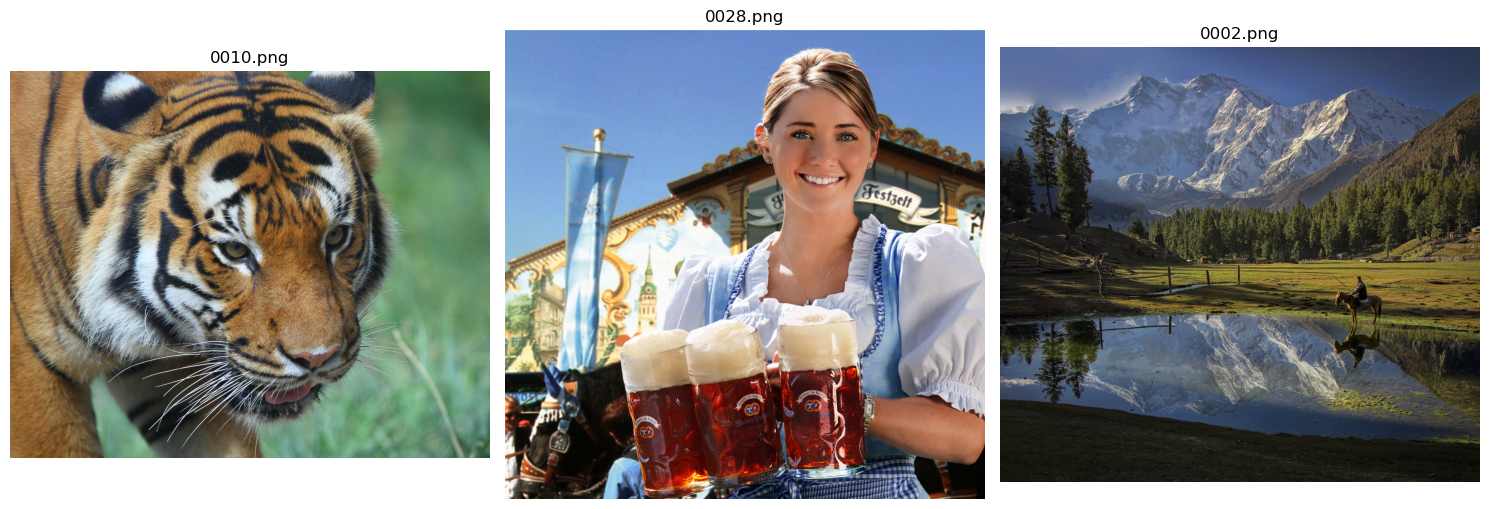

In [ ]:
data_folder = "data"

# get all image files
image_files = [f for f in os.listdir(data_folder) if f.endswith(("png", "jpg", "jpeg"))]
print(f"Found {len(image_files)} images in {data_folder} folder")

# display a few sample images
num_samples = min(3, len(image_files))
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

for i in range(num_samples):
    img_path = os.path.join(data_folder, image_files[i])
    img = Image.open(img_path)
    if num_samples == 1:
        axes.imshow(img)
        axes.set_title(f"{image_files[i]}")
        axes.axis("off")
    else:
        axes[i].imshow(img)
        axes[i].set_title(f"{image_files[i]}")
        axes[i].axis("off")

plt.tight_layout()
plt.show()

In [5]:
class SinusoidalPositionalEncoding(nn.Module):
    """
    Sinusoidal positional encoding to capture higher-frequency details.
    This helps the network better represent high-frequency details.
    """
    def __init__(self, input_dim=2, num_frequencies=10):
        super().__init__()
        self.input_dim = input_dim
        self.num_frequencies = num_frequencies
        self.output_dim = input_dim * 2 * num_frequencies
        
    def forward(self, x):
        # x has shape [batch_size, input_dim]
        batch_size = x.shape[0]
        
        # Create frequencies for sinusoidal encoding
        # Using powers of 2 for frequencies: 1, 2, 4, 8, ...
        freqs = 2.0 ** torch.arange(self.num_frequencies, device=x.device).float()
        
        # Reshape for broadcasting
        # [batch_size, input_dim] -> [batch_size, input_dim, 1]
        x_reshaped = x.view(batch_size, self.input_dim, 1)
        
        # [num_frequencies] -> [1, 1, num_frequencies]
        freqs_reshaped = freqs.view(1, 1, self.num_frequencies)
        
        # Computing sin and cos embeddings
        # [batch_size, input_dim, num_frequencies]
        args = x_reshaped * freqs_reshaped
        
        # Compute sin and cos
        embedding_sin = torch.sin(args)
        embedding_cos = torch.cos(args)
        
        # Flatten the last two dimensions
        # [batch_size, input_dim, num_frequencies] -> [batch_size, input_dim * num_frequencies]
        embedding_sin = embedding_sin.reshape(batch_size, -1)
        embedding_cos = embedding_cos.reshape(batch_size, -1)
        
        # Concatenate sin and cos embeddings
        # [batch_size, input_dim * num_frequencies * 2]
        embedding = torch.cat([embedding_sin, embedding_cos], dim=-1)
        
        return embedding

class ImprovedINRModel(nn.Module):
    """
    Improved Implicit Neural Representation model with positional encoding.
    """
    def __init__(self, input_dim=2, output_dim=3, hidden_dim=256, num_layers=6, 
                 dropout_rate=0.0, use_positional_encoding=True, num_frequencies=10):
        super().__init__()
        
        self.use_positional_encoding = use_positional_encoding
        
        if use_positional_encoding:
            self.positional_encoding = SinusoidalPositionalEncoding(
                input_dim=input_dim, 
                num_frequencies=num_frequencies
            )
            encoding_dim = self.positional_encoding.output_dim
        else:
            encoding_dim = input_dim
        
        # Network architecture
        layers = []
        
        # First layer
        layers.append(nn.Linear(encoding_dim, hidden_dim))
        layers.append(nn.ReLU())
        
        # Hidden layers
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
        
        # Output layer
        layers.append(nn.Linear(hidden_dim, output_dim))
        layers.append(nn.Sigmoid())  # Ensure output is in [0, 1] range
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        # Apply positional encoding if used
        if self.use_positional_encoding:
            x = self.positional_encoding(x)
            
        return self.network(x)
    
    def train_model(self, dataloader, num_epochs=100, lr=1e-3, weight_decay=1e-5,
                    device='cpu', criterion=nn.MSELoss(), scheduler_gamma=0.95):
        """
        Train the model with learning rate scheduling and weight decay.
        """
        optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)
        
        self.train()
        self.to(device)
        
        losses = []
        
        for epoch in tqdm(range(num_epochs)):
            total_loss = 0
            
            for batch_coords, batch_pixels in dataloader:
                batch_coords = batch_coords.to(device)
                batch_pixels = batch_pixels.to(device)
                
                # Forward pass
                pred_pixels = self(batch_coords)
                
                # Compute loss
                loss = criterion(pred_pixels, batch_pixels)
                total_loss += loss.item()
                
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            # Apply learning rate scheduling
            scheduler.step()
            
            avg_loss = total_loss / len(dataloader)
            losses.append(avg_loss)
            
            if epoch % 10 == 0 or epoch == num_epochs - 1:
                print(f"Epoch {epoch}, Loss: {avg_loss:.6f}, LR: {scheduler.get_last_lr()[0]:.6f}")
        
        return losses

In [6]:
def get_normalized_coordinates(h, w):
    """Generate normalized coordinate grid (0 to 1) for an image"""
    y = np.linspace(0, 1, h)
    x = np.linspace(0, 1, w)
    X, Y = np.meshgrid(x, y)
    coords = np.stack([X, Y], axis=-1)  # [h, w, 2]
    return coords.reshape(-1, 2)  # Flatten to [h*w, 2]

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, coordinates, pixel_values):
        self.coordinates = torch.from_numpy(coordinates.astype(np.float32))
        self.pixel_values = torch.from_numpy(pixel_values.astype(np.float32))
    
    def __len__(self):
        return len(self.coordinates)
    
    def __getitem__(self, idx):
        coord = self.coordinates[idx]
        pixel = self.pixel_values[idx]
        return coord, pixel

def downsample_image(img, factor):
    """Downsample an image by a given factor"""
    w, h = img.size
    return img.resize((w // factor, h // factor), Image.LANCZOS)

def calculate_metrics(original, reconstructed):
    """Calculate PSNR and SSIM metrics between original and reconstructed images"""
    # Convert to numpy arrays if they're not alreadypss
    if isinstance(original, torch.Tensor):
        original = original.cpu().numpy()
    if isinstance(reconstructed, torch.Tensor):
        reconstructed = reconstructed.cpu().numpy()
    
    # Make sure images are in the right format for the metrics
    original = original.astype(np.float32) / 255.0 if original.max() > 1.0 else original.astype(np.float32)
    reconstructed = reconstructed.astype(np.float32) / 255.0 if reconstructed.max() > 1.0 else reconstructed.astype(np.float32)
    
    # Calculate metrics
    psnr_value = psnr(original, reconstructed, data_range=1.0)
    ssim_value = ssim(original, reconstructed, channel_axis=2, data_range=1.0)
    
    return psnr_value, ssim_value

In [7]:
def train_inr_for_image(img_path, downscale_factor=4, target_scale=None, 
                        hidden_dim=256, num_layers=6, num_epochs=200, 
                        batch_size=4096, learning_rate=1e-3, weight_decay=1e-5,
                        use_positional_encoding=True, num_frequencies=10,
                        scheduler_gamma=0.95, device=None):
    """
    Train an INR model for a single image.
    
    Args:
        img_path: Path to the image
        downscale_factor: Factor to downsample the image for training
        target_scale: Optional different scale for upsampling (default: same as downscale)
        hidden_dim: Hidden dimension size of the model
        num_layers: Number of layers in the model
        num_epochs: Number of training epochs
        batch_size: Batch size for training
        learning_rate: Initial learning rate
        weight_decay: Weight decay for regularization
        use_positional_encoding: Whether to use positional encoding
        num_frequencies: Number of frequencies for positional encoding
        scheduler_gamma: Gamma value for learning rate scheduler
        device: Device to train on (default: auto-detect)
        
    Returns:
        model: Trained INR model
        metrics: Dictionary of metrics including PSNR and SSIM
        images: Dictionary containing original, downsampled, and reconstructed images
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Set target scale if not provided
    if target_scale is None:
        target_scale = downscale_factor
    
    # Load the image
    img_original = Image.open(img_path)
    img_np_original = np.array(img_original)
    
    # Get original dimensions
    height_original, width_original, channels = img_np_original.shape
    print(f"Original image dimensions: {height_original}x{width_original}, {channels} channels")
    
    # Downsample image
    img_downsampled = downsample_image(img_original, downscale_factor)
    img_np_downsampled = np.array(img_downsampled)
    height_downsampled, width_downsampled, _ = img_np_downsampled.shape
    print(f"Downsampled image dimensions: {height_downsampled}x{width_downsampled}")
    
    # Normalize pixel values to [0, 1]
    img_np_downsampled_normalized = img_np_downsampled.astype(np.float32) / 255.0
    
    # Generate coordinates
    normalized_coordinates = get_normalized_coordinates(height_downsampled, width_downsampled)
    pixel_values = img_np_downsampled_normalized.reshape(-1, channels)
    
    # Create dataset and dataloader
    dataset = ImageDataset(normalized_coordinates, pixel_values)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Create model
    model = ImprovedINRModel(
        input_dim=2, 
        output_dim=channels, 
        hidden_dim=hidden_dim, 
        num_layers=num_layers,
        dropout_rate=0.0,  # We'll use weight decay instead of dropout
        use_positional_encoding=use_positional_encoding,
        num_frequencies=num_frequencies
    )
    
    # Train model
    criterion = nn.MSELoss()
    losses = model.train_model(
        dataloader, 
        num_epochs=num_epochs, 
        lr=learning_rate,
        weight_decay=weight_decay,
        device=device, 
        criterion=criterion,
        scheduler_gamma=scheduler_gamma
    )
    
    # Calculate upsampled dimensions based on target scale
    height_target = height_downsampled * target_scale
    width_target = width_downsampled * target_scale
    print(f"Target upsampled dimensions: {height_target}x{width_target}")
    
    # Generate coordinates for the target upsampled image
    target_coords_normalized = get_normalized_coordinates(height_target, width_target)
    target_coords_tensor = torch.from_numpy(target_coords_normalized).float().to(device)
    
    # Generate the upsampled image
    model.eval()
    with torch.no_grad():
        # Process in batches to avoid CUDA out of memory
        batch_size = 10000
        num_batches = (len(target_coords_tensor) + batch_size - 1) // batch_size
        pred_pixels_list = []
        
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(target_coords_tensor))
            batch = target_coords_tensor[start_idx:end_idx]
            pred_pixels = model(batch).cpu().numpy()
            pred_pixels_list.append(pred_pixels)
        
        pred_pixels = np.concatenate(pred_pixels_list, axis=0)
    
    # Reshape and convert to image
    reconstructed_img = pred_pixels.reshape(height_target, width_target, channels)
    reconstructed_img_uint8 = (reconstructed_img * 255).clip(0, 255).astype(np.uint8)
    
    # Calculate metrics
    # We need to resize the original image to match the target dimensions for fair comparison
    img_original_resized = img_original.resize((width_target, height_target), Image.LANCZOS)
    img_np_original_resized = np.array(img_original_resized)
    
    psnr_value, ssim_value = calculate_metrics(img_np_original_resized, reconstructed_img_uint8)
    
    # Compile results
    metrics = {
        'psnr': psnr_value,
        'ssim': ssim_value,
        'final_loss': losses[-1]
    }
    
    images = {
        'original': img_np_original,
        'downsampled': img_np_downsampled,
        'reconstructed': reconstructed_img_uint8,
        'original_resized': img_np_original_resized
    }
    
    return model, metrics, images, losses

In [8]:
# Choose an image to train on
img_file = '0002.png'  # You can change this to any image in your data folder
img_path = os.path.join(data_folder, img_file)

# Parameters
downscale_factor = 4  # How much to downsample the original image
target_scale = 4      # Upsampling factor (can be different from downscale_factor)
hidden_dim = 256      # Model hidden dimension
num_layers = 6        # Number of layers in the model
num_epochs = 300      # Training epochs
batch_size = 4096     # Batch size

# Train the model
model, metrics, images, losses = train_inr_for_image(
    img_path, 
    downscale_factor=downscale_factor,
    target_scale=target_scale,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    num_epochs=num_epochs,
    batch_size=batch_size,
    learning_rate=5e-4,
    weight_decay=1e-6,
    use_positional_encoding=True,
    num_frequencies=10,
    scheduler_gamma=0.98
)

Using device: cpu
Original image dimensions: 1848x2040, 3 channels
Downsampled image dimensions: 462x510


  0%|          | 1/300 [00:01<09:37,  1.93s/it]

Epoch 0, Loss: 0.032110, LR: 0.000490


  4%|▎         | 11/300 [00:20<08:38,  1.80s/it]

Epoch 10, Loss: 0.003131, LR: 0.000400


  7%|▋         | 21/300 [00:38<08:42,  1.87s/it]

Epoch 20, Loss: 0.002339, LR: 0.000327


 10%|█         | 31/300 [00:56<08:10,  1.82s/it]

Epoch 30, Loss: 0.001988, LR: 0.000267


 14%|█▎        | 41/300 [01:15<08:06,  1.88s/it]

Epoch 40, Loss: 0.001800, LR: 0.000218


 17%|█▋        | 51/300 [01:33<07:18,  1.76s/it]

Epoch 50, Loss: 0.001678, LR: 0.000178


 20%|██        | 61/300 [01:51<07:18,  1.83s/it]

Epoch 60, Loss: 0.001580, LR: 0.000146


 24%|██▎       | 71/300 [02:09<06:53,  1.80s/it]

Epoch 70, Loss: 0.001505, LR: 0.000119


 27%|██▋       | 81/300 [02:27<06:31,  1.79s/it]

Epoch 80, Loss: 0.001449, LR: 0.000097


 30%|███       | 91/300 [02:45<06:10,  1.77s/it]

Epoch 90, Loss: 0.001404, LR: 0.000080


 34%|███▎      | 101/300 [03:03<05:50,  1.76s/it]

Epoch 100, Loss: 0.001372, LR: 0.000065


 37%|███▋      | 111/300 [03:20<05:32,  1.76s/it]

Epoch 110, Loss: 0.001338, LR: 0.000053


 40%|████      | 121/300 [03:38<05:14,  1.76s/it]

Epoch 120, Loss: 0.001315, LR: 0.000043


 44%|████▎     | 131/300 [03:56<04:58,  1.76s/it]

Epoch 130, Loss: 0.001299, LR: 0.000035


 47%|████▋     | 141/300 [04:14<04:42,  1.78s/it]

Epoch 140, Loss: 0.001283, LR: 0.000029


 50%|█████     | 151/300 [04:31<04:27,  1.79s/it]

Epoch 150, Loss: 0.001269, LR: 0.000024


 54%|█████▎    | 161/300 [04:49<04:08,  1.79s/it]

Epoch 160, Loss: 0.001258, LR: 0.000019


 57%|█████▋    | 171/300 [05:07<03:55,  1.83s/it]

Epoch 170, Loss: 0.001247, LR: 0.000016


 60%|██████    | 181/300 [05:26<03:47,  1.91s/it]

Epoch 180, Loss: 0.001239, LR: 0.000013


 64%|██████▎   | 191/300 [05:44<03:23,  1.87s/it]

Epoch 190, Loss: 0.001234, LR: 0.000011


 67%|██████▋   | 201/300 [06:04<03:10,  1.93s/it]

Epoch 200, Loss: 0.001228, LR: 0.000009


 70%|███████   | 211/300 [06:21<02:35,  1.75s/it]

Epoch 210, Loss: 0.001222, LR: 0.000007


 74%|███████▎  | 221/300 [06:41<02:33,  1.94s/it]

Epoch 220, Loss: 0.001219, LR: 0.000006


 77%|███████▋  | 231/300 [07:00<02:14,  1.95s/it]

Epoch 230, Loss: 0.001216, LR: 0.000005


 80%|████████  | 241/300 [07:18<01:42,  1.74s/it]

Epoch 240, Loss: 0.001213, LR: 0.000004


 84%|████████▎ | 251/300 [07:35<01:23,  1.70s/it]

Epoch 250, Loss: 0.001211, LR: 0.000003


 87%|████████▋ | 261/300 [07:52<01:04,  1.66s/it]

Epoch 260, Loss: 0.001209, LR: 0.000003


 90%|█████████ | 271/300 [08:08<00:48,  1.69s/it]

Epoch 270, Loss: 0.001208, LR: 0.000002


 94%|█████████▎| 281/300 [08:25<00:32,  1.71s/it]

Epoch 280, Loss: 0.001207, LR: 0.000002


 97%|█████████▋| 291/300 [08:44<00:16,  1.82s/it]

Epoch 290, Loss: 0.001205, LR: 0.000001


100%|██████████| 300/300 [09:00<00:00,  1.80s/it]

Epoch 299, Loss: 0.001205, LR: 0.000001
Target upsampled dimensions: 1848x2040


Super-resolution results:
PSNR: 22.83 dB
SSIM: 0.5113
Final training loss: 0.001205


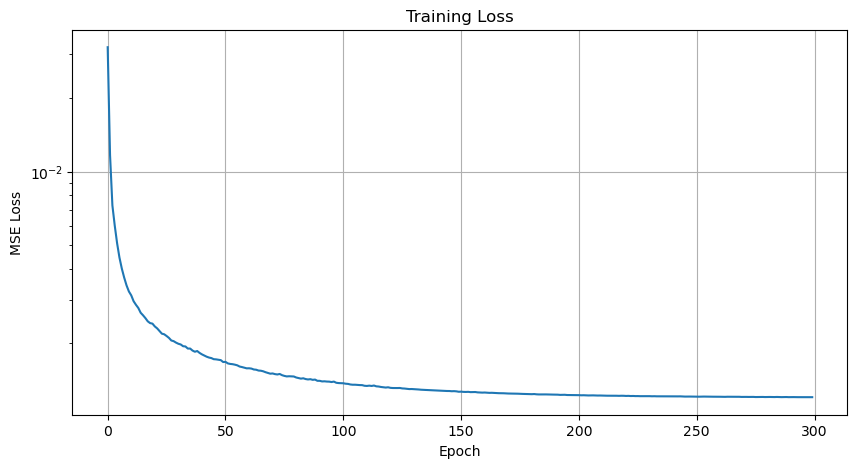

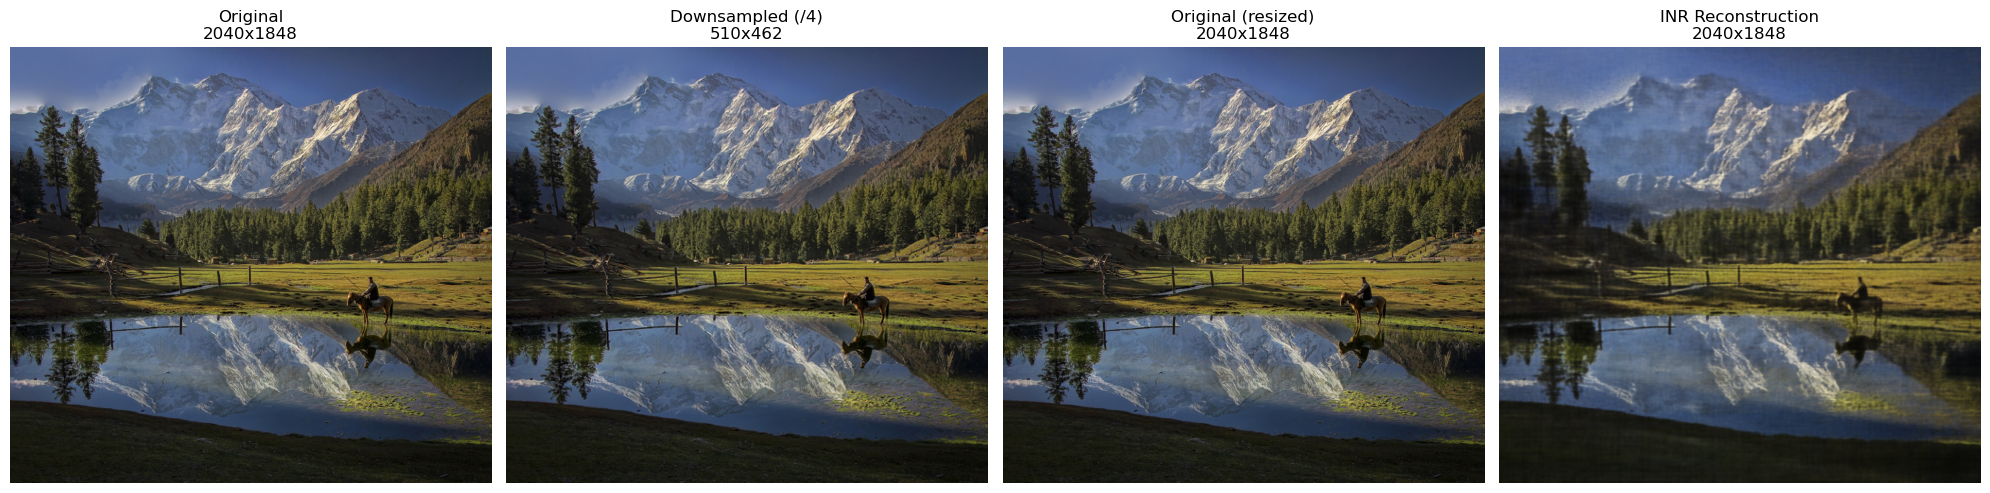

In [9]:
# Print metrics
print(f"Super-resolution results:")
print(f"PSNR: {metrics['psnr']:.2f} dB")
print(f"SSIM: {metrics['ssim']:.4f}")
print(f"Final training loss: {metrics['final_loss']:.6f}")

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title(f'Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.yscale('log')  # Log scale makes it easier to see progress
plt.show()

# Display images
fig, axes = plt.subplots(1, 4, figsize=(20, 10))

# Original image
axes[0].imshow(images['original'])
axes[0].set_title(f"Original\n{images['original'].shape[1]}x{images['original'].shape[0]}")
axes[0].axis('off')

# Downsampled image
axes[1].imshow(images['downsampled'])
axes[1].set_title(f"Downsampled (/{downscale_factor})\n{images['downsampled'].shape[1]}x{images['downsampled'].shape[0]}")
axes[1].axis('off')

# Original resized image (for comparison)
axes[2].imshow(images['original_resized'])
axes[2].set_title(f"Original (resized)\n{images['original_resized'].shape[1]}x{images['original_resized'].shape[0]}")
axes[2].axis('off')

# Reconstructed image
axes[3].imshow(images['reconstructed'])
axes[3].set_title(f"INR Reconstruction\n{images['reconstructed'].shape[1]}x{images['reconstructed'].shape[0]}")
axes[3].axis('off')

plt.tight_layout()
plt.show()

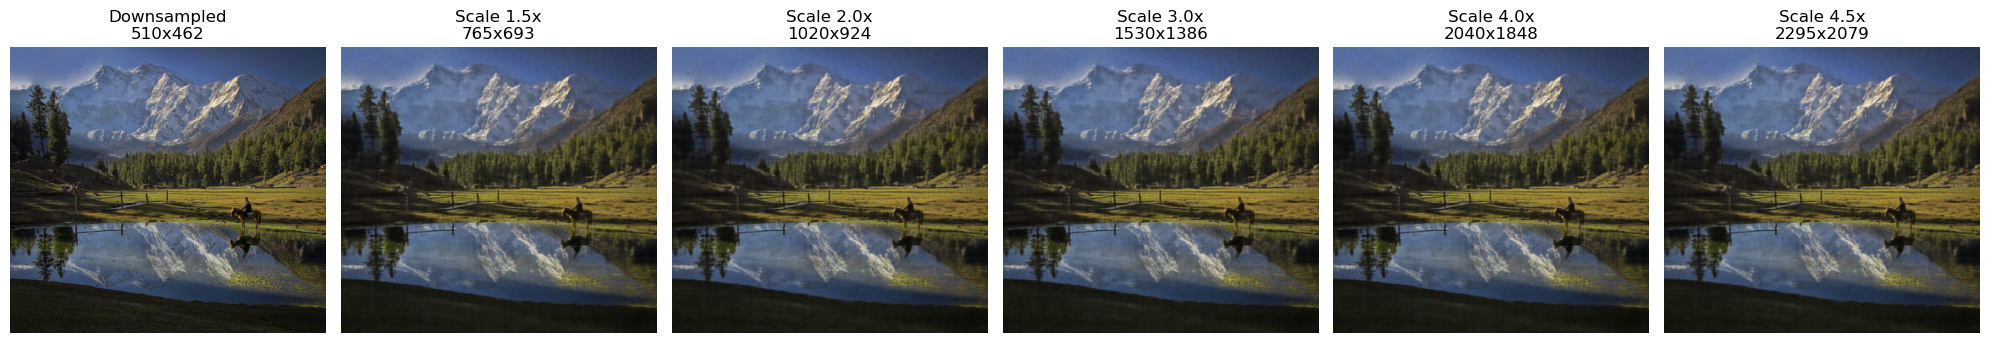

In [10]:
def generate_upscaled_image(model, width, height, channels, device):
    """Generate an upscaled image with the given dimensions using the trained model"""
    # Generate coordinates
    coords = get_normalized_coordinates(height, width)
    coords_tensor = torch.from_numpy(coords).float().to(device)
    
    # Generate the image
    model.eval()
    with torch.no_grad():
        # Process in batches to avoid CUDA out of memory
        batch_size = 10000
        num_batches = (len(coords_tensor) + batch_size - 1) // batch_size
        pred_pixels_list = []
        
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(coords_tensor))
            batch = coords_tensor[start_idx:end_idx]
            pred_pixels = model(batch).cpu().numpy()
            pred_pixels_list.append(pred_pixels)
        
        pred_pixels = np.concatenate(pred_pixels_list, axis=0)
    
    # Reshape and convert to image
    reconstructed_img = pred_pixels.reshape(height, width, channels)
    reconstructed_img_uint8 = (reconstructed_img * 255).clip(0, 255).astype(np.uint8)
    
    return reconstructed_img_uint8

# Get dimensions of the downsampled image
height_downsampled, width_downsampled, channels = images['downsampled'].shape

# Generate images at different scales
scales = [1.5, 2.0, 3.0, 4.0, 4.5]
upscaled_images = {}

device = next(model.parameters()).device  # Get the device the model is on

for scale in scales:
    # Calculate dimensions at this scale
    height = int(height_downsampled * scale)
    width = int(width_downsampled * scale)
    
    # Generate image
    upscaled_img = generate_upscaled_image(model, width, height, channels, device)
    upscaled_images[scale] = upscaled_img

# Display images at different scales
fig, axes = plt.subplots(1, len(scales) + 1, figsize=(20, 8))

# Original downsampled image
axes[0].imshow(images['downsampled'])
axes[0].set_title(f"Downsampled\n{width_downsampled}x{height_downsampled}")
axes[0].axis('off')

# Upscaled images
for i, scale in enumerate(scales):
    img = upscaled_images[scale]
    axes[i+1].imshow(img)
    axes[i+1].set_title(f"Scale {scale}x\n{img.shape[1]}x{img.shape[0]}")
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

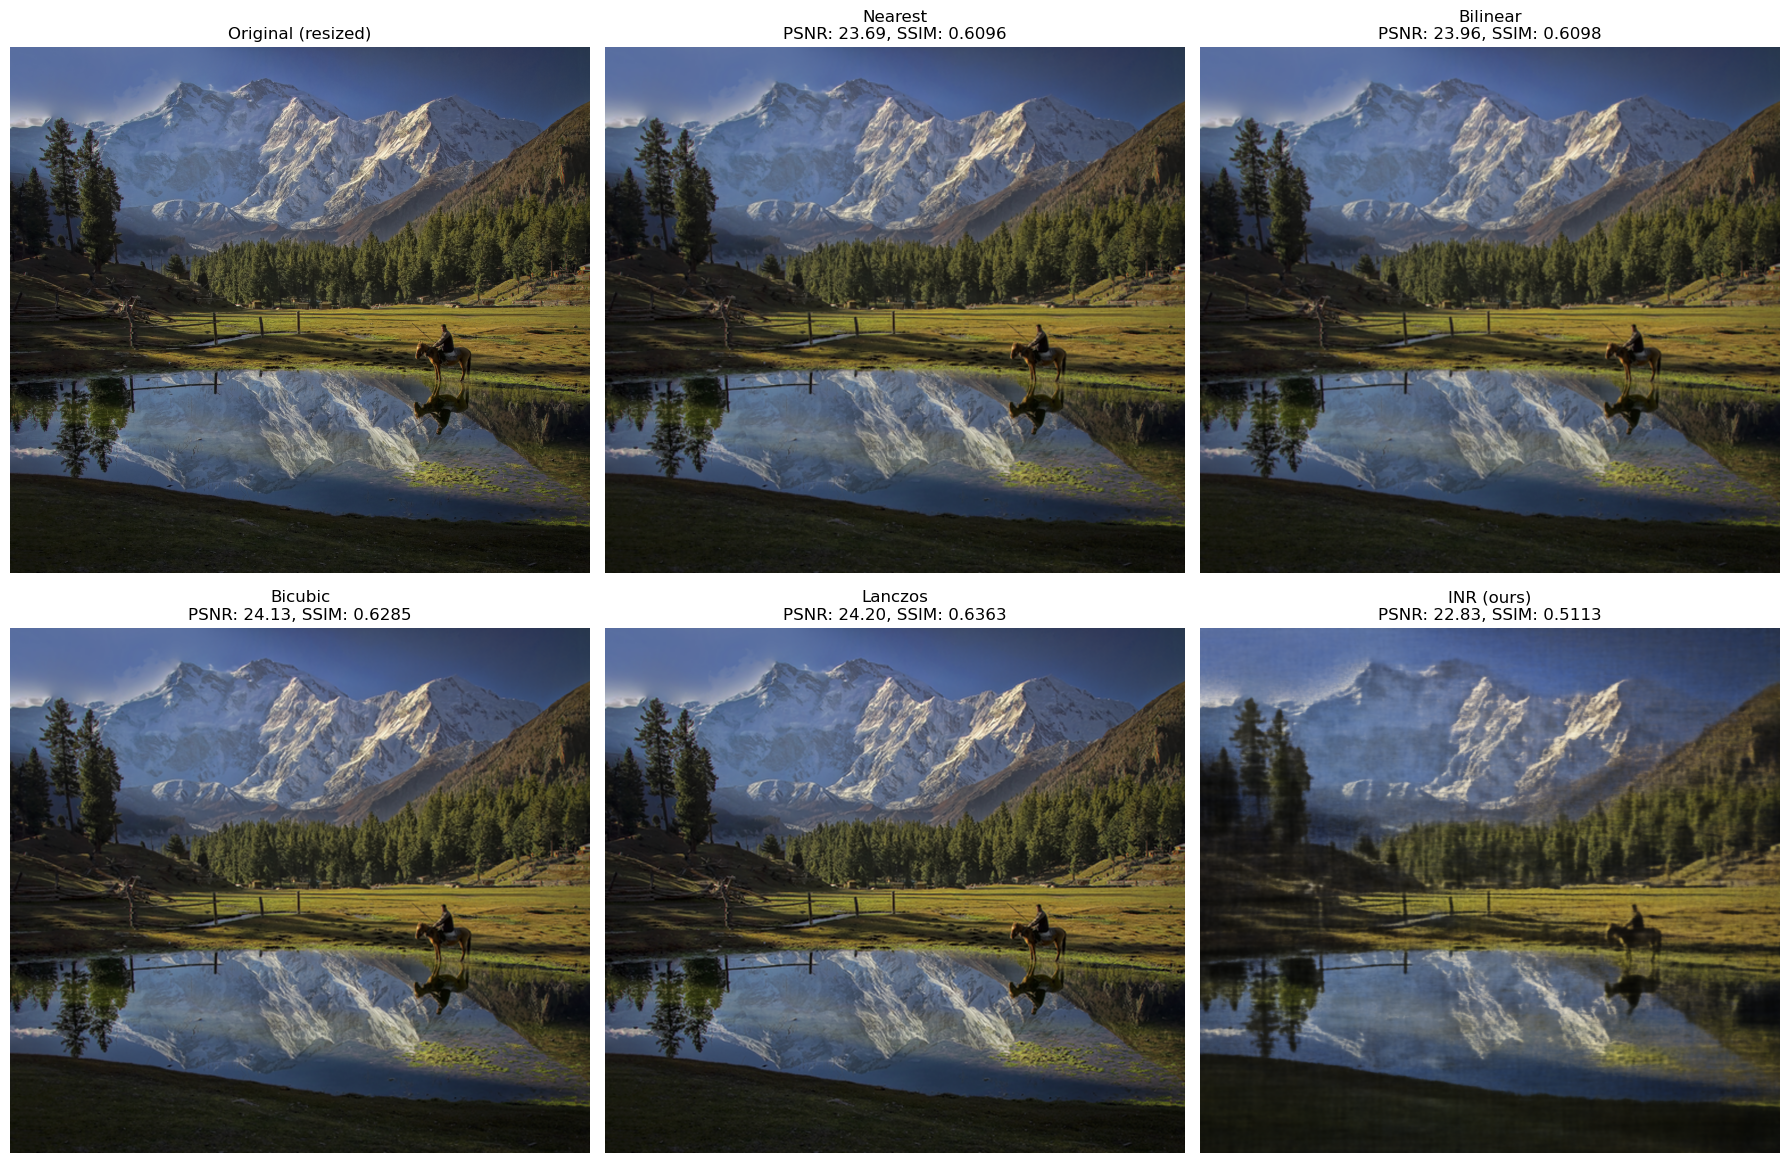

Method		PSNR (dB)	SSIM
----------------------------------------
Nearest		23.69		0.6096
Bilinear	23.96		0.6098
Bicubic		24.13		0.6285
Lanczos		24.20		0.6363
INR (ours)	22.83		0.5113


In [11]:
# Let's compare our INR-based method with traditional interpolation methods
from PIL import Image

# Get dimensions of the downsampled image
height_downsampled, width_downsampled = images['downsampled'].shape[:2]

# Target scale
scale = 4.0
target_width = int(width_downsampled * scale)
target_height = int(height_downsampled * scale)

# Upscale using traditional methods
img_downsampled_pil = Image.fromarray(images['downsampled'])

upscaled_nearest = np.array(img_downsampled_pil.resize((target_width, target_height), Image.NEAREST))
upscaled_bilinear = np.array(img_downsampled_pil.resize((target_width, target_height), Image.BILINEAR))
upscaled_bicubic = np.array(img_downsampled_pil.resize((target_width, target_height), Image.BICUBIC))
upscaled_lanczos = np.array(img_downsampled_pil.resize((target_width, target_height), Image.LANCZOS))

# Calculate metrics
psnr_nearest, ssim_nearest = calculate_metrics(images['original_resized'], upscaled_nearest)
psnr_bilinear, ssim_bilinear = calculate_metrics(images['original_resized'], upscaled_bilinear)
psnr_bicubic, ssim_bicubic = calculate_metrics(images['original_resized'], upscaled_bicubic)
psnr_lanczos, ssim_lanczos = calculate_metrics(images['original_resized'], upscaled_lanczos)
psnr_inr, ssim_inr = metrics['psnr'], metrics['ssim']

# Display results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Original image (resized)
axes[0].imshow(images['original_resized'])
axes[0].set_title(f"Original (resized)")
axes[0].axis('off')

# Nearest neighbor
axes[1].imshow(upscaled_nearest)
axes[1].set_title(f"Nearest\nPSNR: {psnr_nearest:.2f}, SSIM: {ssim_nearest:.4f}")
axes[1].axis('off')

# Bilinear
axes[2].imshow(upscaled_bilinear)
axes[2].set_title(f"Bilinear\nPSNR: {psnr_bilinear:.2f}, SSIM: {ssim_bilinear:.4f}")
axes[2].axis('off')

# Bicubic
axes[3].imshow(upscaled_bicubic)
axes[3].set_title(f"Bicubic\nPSNR: {psnr_bicubic:.2f}, SSIM: {ssim_bicubic:.4f}")
axes[3].axis('off')

# Lanczos
axes[4].imshow(upscaled_lanczos)
axes[4].set_title(f"Lanczos\nPSNR: {psnr_lanczos:.2f}, SSIM: {ssim_lanczos:.4f}")
axes[4].axis('off')

# INR (ours)
axes[5].imshow(images['reconstructed'])
axes[5].set_title(f"INR (ours)\nPSNR: {psnr_inr:.2f}, SSIM: {ssim_inr:.4f}")
axes[5].axis('off')

plt.tight_layout()
plt.show()

# Print results in a table
print("Method\t\tPSNR (dB)\tSSIM")
print("-" * 40)
print(f"Nearest\t\t{psnr_nearest:.2f}\t\t{ssim_nearest:.4f}")
print(f"Bilinear\t{psnr_bilinear:.2f}\t\t{ssim_bilinear:.4f}")
print(f"Bicubic\t\t{psnr_bicubic:.2f}\t\t{ssim_bicubic:.4f}")
print(f"Lanczos\t\t{psnr_lanczos:.2f}\t\t{ssim_lanczos:.4f}")
print(f"INR (ours)\t{psnr_inr:.2f}\t\t{ssim_inr:.4f}")

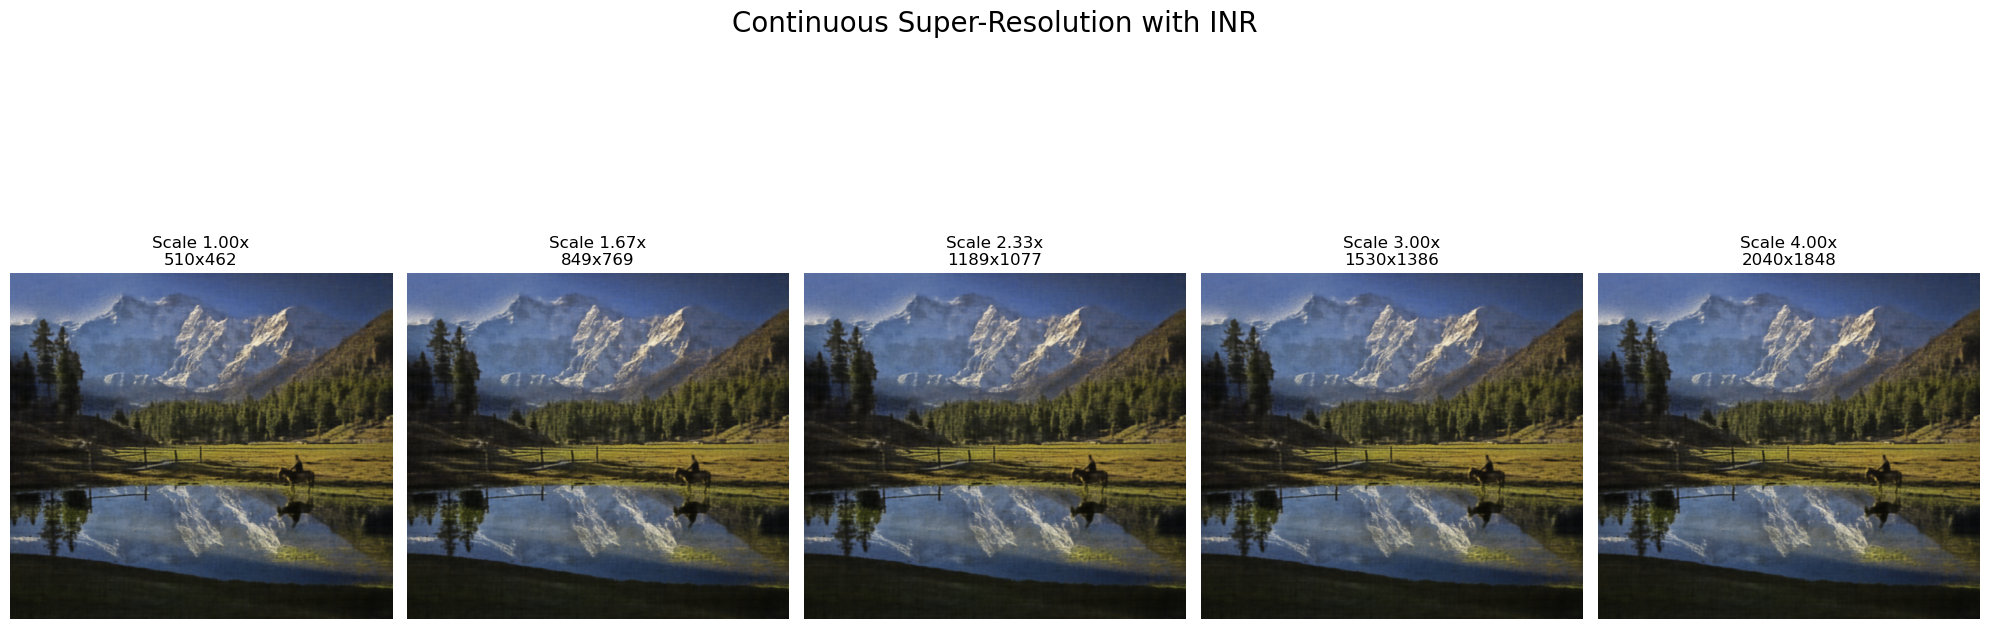

In [13]:
# Let's create a visualization of continuous upscaling
# This shows the INR's ability to generate images at any scale

# Define a range of continuous scales
continuous_scales = np.linspace(1.0, 4.0, 10)  # 10 scales from 1.0x to 4.0x

# Generate images at these scales
continuous_images = []
widths = []
heights = []

for scale in continuous_scales:
    height = int(height_downsampled * scale)
    width = int(width_downsampled * scale)
    widths.append(width)
    heights.append(height)
    
    upscaled_img = generate_upscaled_image(model, width, height, channels, device)
    continuous_images.append(upscaled_img)

# Create animation frames (optional, uncomment to save as individual frames)
import os
os.makedirs('animation_frames', exist_ok=True)
for i, img in enumerate(continuous_images):
    Image.fromarray(img).save(f'animation_frames/frame_{i:03d}.png')

# Display a subset of the frames
num_display = 5
indices = np.linspace(0, len(continuous_scales)-1, num_display).astype(int)

fig, axes = plt.subplots(1, num_display, figsize=(20, 8))

for i, idx in enumerate(indices):
    scale = continuous_scales[idx]
    img = continuous_images[idx]
    axes[i].imshow(img)
    axes[i].set_title(f"Scale {scale:.2f}x\n{widths[idx]}x{heights[idx]}")
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle("Continuous Super-Resolution with INR", fontsize=20, y=0.98)
plt.subplots_adjust(top=0.85)
plt.show()